# Reinforcement Learning for Adaptive Warehouse Management

## ENVIRONMENT SETUP

Deleting Local Variables to make space for other algorithms

In [1]:
for var in list(globals().keys()):
    if var[0] != '_' and var not in ['gc', 'del']:
        del globals()[var]

In [2]:
import gc
gc.collect()

35

In [3]:
import numpy as np
import gym
from collections import defaultdict
import random
import time
import matplotlib.pyplot as plt
from collections import deque
import pandas as pd
from tabulate import tabulate
import gc

class WarehouseEnv(gym.Env):
    def __init__(self, num_items=50, num_aisles=10):
        self.grid_size = (num_items, num_aisles)
        self.num_items = num_items
        self.num_aisles = num_aisles
        self.max_orders = int(0.2*num_aisles*num_items)
        self.action_space = gym.spaces.Discrete(6)  # up, down, left, right, pick, drop
        self.observation_space = gym.spaces.Dict({
            'robot_position': gym.spaces.Box(low=0, high=max(self.grid_size), shape=(2,), dtype=int),
            'item_locations': gym.spaces.Tuple((gym.spaces.Box(low=0, high=max(self.grid_size), shape=(2,), dtype=int),) * (self.grid_size[0] * self.grid_size[1] // 5)),
            'inventory_levels': gym.spaces.Dict({i: gym.spaces.Discrete(100) for i in range(num_items)}),
            'order_queue': gym.spaces.Tuple((gym.spaces.Discrete(num_items),) * self.max_orders),
            'battery_level': gym.spaces.Box(low=0, high=100, shape=(1,), dtype=float),
            'robot_inventory': gym.spaces.Discrete(num_items + 1),  # +1 for empty inventory
        })
        self.reset()


    def reset(self):
        self.robot_position = [0, 0]

        # Fill 20% of the space with items
        num_filled_cells = int(0.2 * self.grid_size[0] * self.grid_size[1])
        self.item_locations = []
        while len(self.item_locations) < num_filled_cells:
            pos = (np.random.randint(0, self.grid_size[0]), np.random.randint(0, self.grid_size[1]))
            if pos not in self.item_locations:
                self.item_locations.append(pos)

        self.inventory_levels = {i: np.random.randint(0, 100) for i in range(self.num_items)}

        # Generate order queue (allowing for 0 orders randomly)
        num_orders = np.random.randint(0, self.max_orders + 1)
        self.order_queue = [np.random.randint(0, self.num_items) for _ in range(num_orders)]

        self.battery_level = 100.0
        self.robot_inventory = None
        return self._get_state()

    def step(self, action):
        battery_died_count = 0
        orders_fulfilled_count = 0
        reward = -0.5 # Base cost for each action (very small since a bigger base cost might discourage exploration)
        done = False

        if action < 4:  # Movement actions
            self._move(action)
            self.battery_level -= 0.5
        elif action == 4:  # Pick
            reward += self._pick_item()
        elif action == 5:  # Drop
            reward += self._drop_item()

        if self.battery_level <= 0:
            done = True
            reward -= 50  # Penalty for running out of battery
            battery_died_count += 1
            #self.battery_level = 50.0 # Battery Recharge (reduce the efficiency for recharging)

        if len(self.order_queue) == 0:
            done = True
            reward += 200
            orders_fulfilled_count += 1

        return self._get_state(), reward, done, {}

    def _move(self, direction):
        if direction == 0:  # up
            self.robot_position[0] = max(0, self.robot_position[0] - 1)
        elif direction == 1:  # down
            self.robot_position[0] = min(self.grid_size[0] - 1, self.robot_position[0] + 1)
        elif direction == 2:  # left
            self.robot_position[1] = max(0, self.robot_position[1] - 1)
        elif direction == 3:  # right
            self.robot_position[1] = min(self.grid_size[1] - 1, self.robot_position[1] + 1)

    def _pick_item(self):
        self.battery_level -= 0.5  # Cost for picking an item
        if self.robot_inventory is not None:
            return -2  # Penalty for attempting to pick while already holding an item

        if tuple(self.robot_position) in self.item_locations:
            item_index = self.item_locations.index(tuple(self.robot_position))
            self.robot_inventory = item_index
            self.item_locations.remove(tuple(self.robot_position))
            return 10  # Small reward for successful pick
        return -2  # Penalty for attempting to pick where there's no item

    def _drop_item(self):
        self.battery_level -= 0.5 # Cost for dropping an item
        if self.robot_inventory is None:
            return -2  # Penalty for attempting to drop when not holding an item

        if self.robot_inventory in self.order_queue:
            self.order_queue.remove(self.robot_inventory)
            self.inventory_levels[self.robot_inventory] += 1
            reward = 100  # Base reward for fulfilling an order
            # Additional reward based on the original position of the item in the queue
            reward += 5 * (len(self.order_queue) + 1)  # More reward for fulfilling earlier orders
        else:
            # If we're not fulfilling an order, just place the item back in the warehouse
            self.item_locations.append(tuple(self.robot_position))
            reward = -2 # Penalty for unnecessary movement

        self.robot_inventory = None
        return reward

    def _get_state(self):
        return {
            'robot_position': np.array(self.robot_position),
            'item_locations': tuple(self.item_locations),
            'inventory_levels': self.inventory_levels,
            'order_queue': tuple(self.order_queue),
            'battery_level': np.array([self.battery_level]),
            'robot_inventory': self.robot_inventory if self.robot_inventory is not None else self.num_items
        }

    def render(self):
        grid = np.zeros(self.grid_size, dtype=int)
        for item in self.item_locations:
            grid[item[0], item[1]] = 1
        grid[self.robot_position[0], self.robot_position[1]] = 2
        print("Warehouse Grid (Empty: 0, Items: 1, Robot: 2)")
        print(grid)
        print("Inventory Levels:", self.inventory_levels)
        print("Order Queue:", self.order_queue)
        print("Battery Level: {:.2f}%".format(self.battery_level))
        print("Robot Inventory:", self.robot_inventory)

env = WarehouseEnv()

## Q LEARNING ALGORITHM

- Smaller Space with 5000 episodes
- Bigger Space with 1000 episodes

### Q-Learning (Smaller Space - 5*10)

In [4]:
class QLearningAgent:
    def __init__(self, env, learning_rate=0.01, discount_factor=0.95, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.1):
        self.env = env
        self.action_space = env.action_space.n
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.q_table = defaultdict(lambda: np.zeros(self.action_space))

    def get_state_key(self, state):
        return (
            tuple(state['robot_position']),
            tuple(state['item_locations']),
            tuple(sorted(state['inventory_levels'].items())),
            tuple(state['order_queue']),
            float(state['battery_level'][0]),
            state['robot_inventory']
        )

    def choose_action(self, state):
        state_key = self.get_state_key(state)
        if np.random.rand() <= self.epsilon:
            return self.env.action_space.sample()
        return np.argmax(self.q_table[state_key])

    def update_q_table(self, state, action, reward, next_state):
        state_key = self.get_state_key(state)
        next_state_key = self.get_state_key(next_state)

        best_next_action = np.argmax(self.q_table[next_state_key])
        td_target = reward + self.discount_factor * self.q_table[next_state_key][best_next_action]
        self.q_table[state_key][action] += self.learning_rate * (td_target - self.q_table[state_key][action])

    def decay_epsilon(self):
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)


env = WarehouseEnv(5,10)
agent = QLearningAgent(env)

# Training the Q-Learning agent
episodes = 5000
rewards = []
successes = 0
epsilon_values = []

for episode in range(episodes):
    state = env.reset()
    total_reward = 0
    steps = 0
    episode_successes = 0

    while True:
        action = agent.choose_action(state)
        next_state, reward, done, _ = env.step(action)

        if action == 5 and reward > 100:  # 5 is the 'drop' action and positive reward indicates successful drop
            episode_successes += 1

        agent.update_q_table(state, action, reward, next_state)
        state = next_state
        total_reward += reward
        steps += 1

        if done:
            agent.decay_epsilon()
            break

    successes += episode_successes
    rewards.append(total_reward)
    epsilon_values.append(agent.epsilon)

    if episode % 100 == 0:
        avg_reward_last_100 = np.mean(rewards[-100:])
        print(f"Episode: {episode}, Total Reward: {total_reward}, Average Reward (last 100): {avg_reward_last_100:.2f}")
        print(f"Total Successes: {successes}")
        print(f"Epsilon: {agent.epsilon:.4f}")
        print("--------------------")

print(f"Training completed. Total successes: {successes}")

Episode: 0, Total Reward: -470.10000000000383, Average Reward (last 100): -470.10
Total Successes: 0
Epsilon: 0.9950
--------------------
Episode: 100, Total Reward: -502.100000000008, Average Reward (last 100): -111.11
Total Successes: 207
Epsilon: 0.6027
--------------------
Episode: 200, Total Reward: 199.9, Average Reward (last 100): -142.77
Total Successes: 292
Epsilon: 0.3651
--------------------
Episode: 300, Total Reward: -250.09999999999576, Average Reward (last 100): -134.26
Total Successes: 349
Epsilon: 0.2212
--------------------
Episode: 400, Total Reward: -126.09999999999891, Average Reward (last 100): -124.23
Total Successes: 391
Epsilon: 0.1340
--------------------
Episode: 500, Total Reward: -65.09999999999917, Average Reward (last 100): -117.50
Total Successes: 426
Epsilon: 0.1000
--------------------
Episode: 600, Total Reward: -220.09999999999673, Average Reward (last 100): -129.22
Total Successes: 453
Epsilon: 0.1000
--------------------
Episode: 700, Total Reward:

Average Reward: -116.00787999999807
Sucesses: 1753
Success Rate: 0.3506


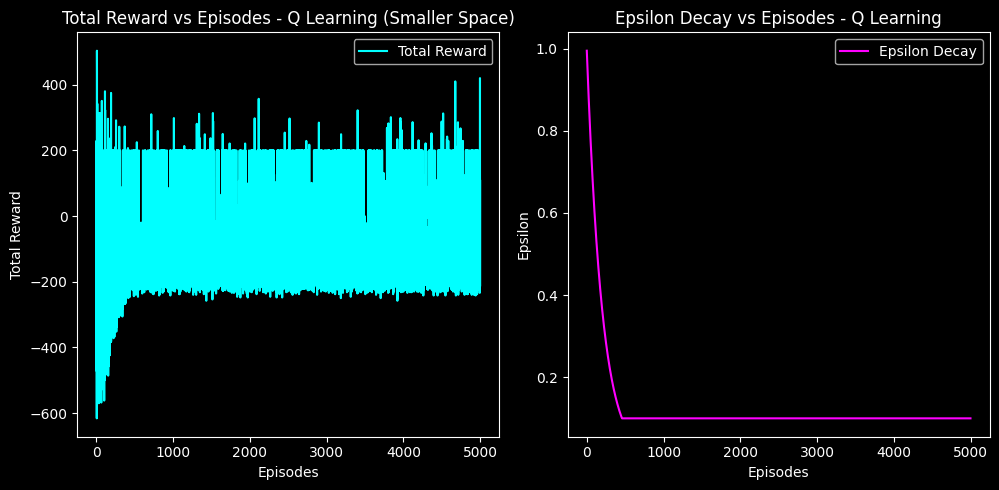

In [6]:
# EVALUATION METRICS
average_reward_ql_ss = np.mean(rewards)
success_rate_ql_ss = successes / episodes
success_ql_ss = successes

print(f"Average Reward: {average_reward_ql_ss}")
print(f"Sucesses: {success_ql_ss}")
print(f"Success Rate: {success_rate_ql_ss}")
plt.style.use('dark_background')
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(rewards, color='cyan', label='Total Reward')
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.title('Total Reward vs Episodes - Q Learning (Smaller Space)')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(epsilon_values, color='magenta', label='Epsilon Decay')
plt.xlabel('Episodes')
plt.ylabel('Epsilon')
plt.title('Epsilon Decay vs Episodes - Q Learning')
plt.legend()


plt.tight_layout()
plt.show()

### Q-Learning - (Bigger Space 50*10)

In [7]:
class QLearningAgent:
    def __init__(self, env, learning_rate=0.01, discount_factor=0.95, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.1):
        self.env = env
        self.action_space = env.action_space.n
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.q_table = defaultdict(lambda: np.zeros(self.action_space))

    def get_state_key(self, state):
        return (
            tuple(state['robot_position']),
            tuple(state['item_locations']),
            tuple(sorted(state['inventory_levels'].items())),
            tuple(state['order_queue']),
            float(state['battery_level'][0]),
            state['robot_inventory']
        )

    def choose_action(self, state):
        state_key = self.get_state_key(state)
        if np.random.rand() <= self.epsilon:
            return self.env.action_space.sample()
        return np.argmax(self.q_table[state_key])

    def update_q_table(self, state, action, reward, next_state):
        state_key = self.get_state_key(state)
        next_state_key = self.get_state_key(next_state)

        best_next_action = np.argmax(self.q_table[next_state_key])
        td_target = reward + self.discount_factor * self.q_table[next_state_key][best_next_action]
        self.q_table[state_key][action] += self.learning_rate * (td_target - self.q_table[state_key][action])

    def decay_epsilon(self):
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)


env = WarehouseEnv(50,10)
agent = QLearningAgent(env)

# Training the Q-Learning agent
episodes = 1000
rewards = []
successes = 0
epsilon_values = []

for episode in range(episodes):
    state = env.reset()
    total_reward = 0
    steps = 0
    episode_successes = 0

    while True:
        action = agent.choose_action(state)
        next_state, reward, done, _ = env.step(action)

        if action == 5 and reward > 100:  # 5 is the 'drop' action and positive reward indicates successful drop
            episode_successes += 1

        agent.update_q_table(state, action, reward, next_state)
        state = next_state
        total_reward += reward
        steps += 1

        if done:
            agent.decay_epsilon()
            break

    successes += episode_successes
    rewards.append(total_reward)
    epsilon_values.append(agent.epsilon)

    if episode % 100 == 0:
        avg_reward_last_100 = np.mean(rewards[-100:])
        print(f"Episode: {episode}, Total Reward: {total_reward}, Average Reward (last 100): {avg_reward_last_100:.2f}")
        print(f"Total Successes: {successes}")
        print(f"Epsilon: {agent.epsilon:.4f}")
        print("--------------------")

print(f"Training completed. Total successes: {successes}")

Episode: 0, Total Reward: 2720.9000000000333, Average Reward (last 100): 2720.90
Total Successes: 7
Epsilon: 0.9950
--------------------
Episode: 100, Total Reward: -526.1000000000071, Average Reward (last 100): 180.13
Total Successes: 176
Epsilon: 0.6027
--------------------
Episode: 200, Total Reward: 49.89999999999366, Average Reward (last 100): 35.16
Total Successes: 264
Epsilon: 0.3651
--------------------
Episode: 300, Total Reward: -262.0999999999962, Average Reward (last 100): -49.24
Total Successes: 323
Epsilon: 0.2212
--------------------
Episode: 400, Total Reward: -232.09999999999712, Average Reward (last 100): -49.69
Total Successes: 362
Epsilon: 0.1340
--------------------
Episode: 500, Total Reward: -220.09999999999698, Average Reward (last 100): -38.54
Total Successes: 399
Epsilon: 0.1000
--------------------
Episode: 600, Total Reward: -230.09999999999653, Average Reward (last 100): -79.11
Total Successes: 425
Epsilon: 0.1000
--------------------
Episode: 700, Total Re

Average Reward: -28.83600000000035
Sucesses: 536
Success Rate: 0.536


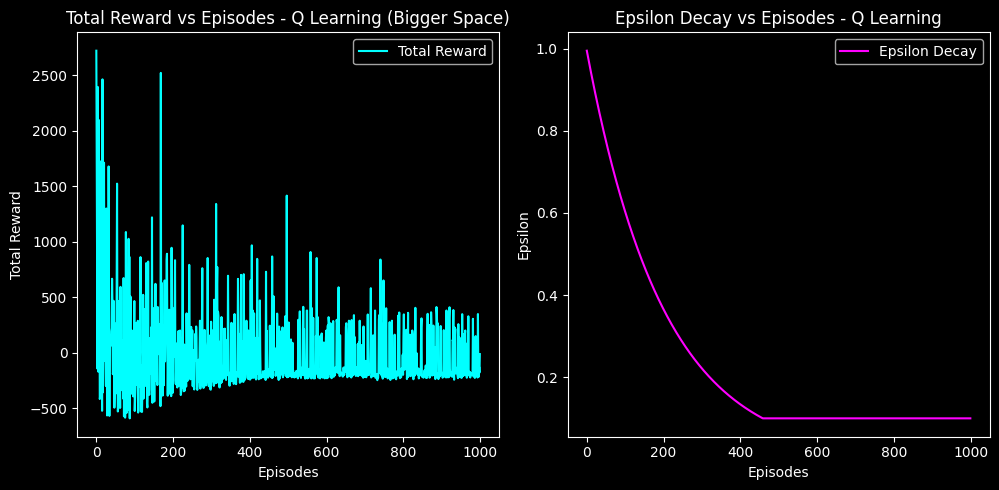

In [8]:
# EVALUATION METRICS
average_reward_ql_bs = np.mean(rewards)
success_rate_ql_bs = successes / episodes
success_ql_bs = successes

print(f"Average Reward: {average_reward_ql_bs}")
print(f"Sucesses: {success_ql_bs}")
print(f"Success Rate: {success_rate_ql_bs}")
plt.style.use('dark_background')
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(rewards, color='cyan', label='Total Reward')
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.title('Total Reward vs Episodes - Q Learning (Bigger Space)')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(epsilon_values, color='magenta', label='Epsilon Decay')
plt.xlabel('Episodes')
plt.ylabel('Epsilon')
plt.title('Epsilon Decay vs Episodes - Q Learning')
plt.legend()


plt.tight_layout()
plt.show()

## SARSA - ALGORITHM

- Smaller Space with 5000 episodes
- Bigger Space with 1000 episodes

### SARSA - (Smaller Space 5*10)

In [9]:
class SARSAAgent:
    def __init__(self, env, learning_rate=0.1, discount_factor=0.95, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.1):
        self.env = env
        self.action_space = env.action_space.n
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.q_table = {}

    def get_state_key(self, state):
        return (
            tuple(state['robot_position']),
            tuple(state['item_locations']),
            tuple(sorted(state['inventory_levels'].items())),
            tuple(state['order_queue']),
            float(state['battery_level'][0]),
            state['robot_inventory']
        )

    def choose_action(self, state):
        state_key = self.get_state_key(state)
        if state_key not in self.q_table:
            self.q_table[state_key] = np.zeros(self.action_space)

        if np.random.rand() <= self.epsilon:
            return self.env.action_space.sample()
        return np.argmax(self.q_table[state_key])

    def update_q_table(self, state, action, reward, next_state, next_action):
        state_key = self.get_state_key(state)
        next_state_key = self.get_state_key(next_state)

        if state_key not in self.q_table:
            self.q_table[state_key] = np.zeros(self.action_space)
        if next_state_key not in self.q_table:
            self.q_table[next_state_key] = np.zeros(self.action_space)

        td_target = reward + self.discount_factor * self.q_table[next_state_key][next_action]
        self.q_table[state_key][action] += self.learning_rate * (td_target - self.q_table[state_key][action])

    def decay_epsilon(self):
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

# Create the environment and agent
env = WarehouseEnv(5,10)
agent = SARSAAgent(env)

# Training the SARSA agent
episodes = 5000
rewards = []
successes = 0
steps_to_goal = []
epsilon_values = []


for episode in range(episodes):
    state = env.reset()
    action = agent.choose_action(state)
    total_reward = 0
    steps = 0
    max_steps_per_episode = 100
    episode_successes = 0

    while True:
        next_state, reward, done, _ = env.step(action)
        next_action = agent.choose_action(next_state)
        agent.update_q_table(state, action, reward, next_state, next_action)
        state = next_state
        action = next_action
        total_reward += reward
        steps += 1

        # Check if an order was fulfilled (item successfully dropped)
        if action == 5 and reward >= 100:  #  5 is the 'drop' action and reward >= 0 indicates success
            episode_successes += 1
            steps_to_goal.append(steps)

        if done or steps >= max_steps_per_episode:
            break

    successes += episode_successes
    agent.decay_epsilon()
    rewards.append(total_reward)
    epsilon_values.append(agent.epsilon)

    if episode % 100 == 0:
        avg_reward_last_100 = np.mean(rewards[-100:]) if len(rewards) >= 100 else np.mean(rewards)
        print(f"Episode: {episode}/{episodes}, Total Reward: {total_reward}, Average Reward (last 100): {avg_reward_last_100:.2f}")
        print(f"Total Successes: {successes}")
        print(f"Epsilon: {agent.epsilon:.4f}")
        print("--------------------")

print(f"Training completed. Total successes: {successes}")


Episode: 0/5000, Total Reward: -91.99999999999991, Average Reward (last 100): -92.00
Total Successes: 0
Epsilon: 0.9950
--------------------
Episode: 100/5000, Total Reward: 13.999999999999972, Average Reward (last 100): 31.51
Total Successes: 11
Epsilon: 0.6027
--------------------
Episode: 200/5000, Total Reward: -34.00000000000004, Average Reward (last 100): 21.92
Total Successes: 13
Epsilon: 0.3651
--------------------
Episode: 300/5000, Total Reward: 199.9, Average Reward (last 100): 17.12
Total Successes: 13
Epsilon: 0.2212
--------------------
Episode: 400/5000, Total Reward: -7.999999999999986, Average Reward (last 100): 2.39
Total Successes: 13
Epsilon: 0.1340
--------------------
Episode: 500/5000, Total Reward: -17.999999999999996, Average Reward (last 100): 7.79
Total Successes: 14
Epsilon: 0.1000
--------------------
Episode: 600/5000, Total Reward: -18.000000000000014, Average Reward (last 100): 6.02
Total Successes: 14
Epsilon: 0.1000
--------------------
Episode: 700/50

Average Reward: 10.319840000000013
Sucesses: 25
Success Rate: 0.005


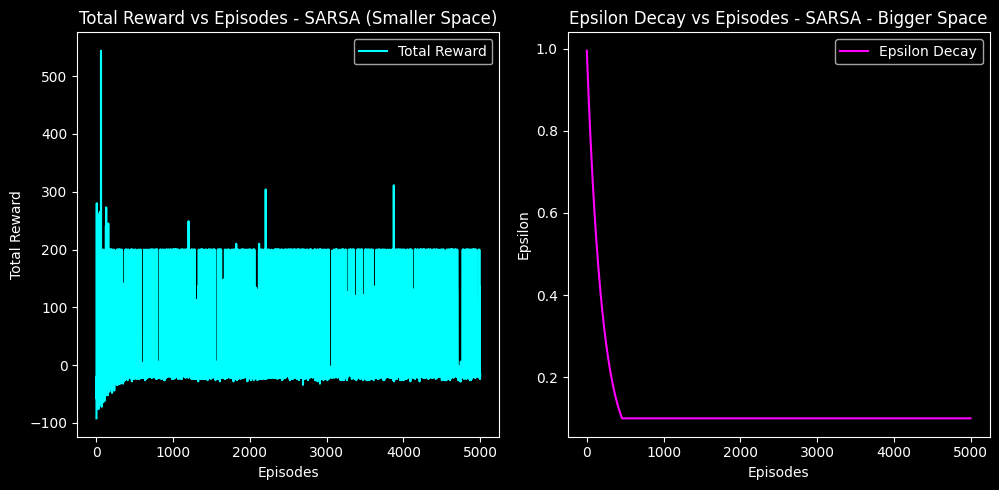

In [10]:
# EVALUATION METRICS
average_reward_sarsa_ss = np.mean(rewards)
success_rate_sarsa_ss = successes / episodes
success_sarsa_ss = successes

print(f"Average Reward: {average_reward_sarsa_ss}")
print(f"Sucesses: {success_sarsa_ss}")
print(f"Success Rate: {success_rate_sarsa_ss}")
plt.style.use('dark_background')
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(rewards, color='cyan', label='Total Reward')
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.title('Total Reward vs Episodes - SARSA (Smaller Space)')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(epsilon_values, color='magenta', label='Epsilon Decay')
plt.xlabel('Episodes')
plt.ylabel('Epsilon')
plt.title('Epsilon Decay vs Episodes - SARSA - Bigger Space')
plt.legend()


plt.tight_layout()
plt.show()

### SARSA - (Bigger Space 5*10)

In [11]:
class SARSAAgent:
    def __init__(self, env, learning_rate=0.1, discount_factor=0.95, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.1):
        self.env = env
        self.action_space = env.action_space.n
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.q_table = {}

    def get_state_key(self, state):
        return (
            tuple(state['robot_position']),
            tuple(state['item_locations']),
            tuple(sorted(state['inventory_levels'].items())),
            tuple(state['order_queue']),
            float(state['battery_level'][0]),
            state['robot_inventory']
        )

    def choose_action(self, state):
        state_key = self.get_state_key(state)
        if state_key not in self.q_table:
            self.q_table[state_key] = np.zeros(self.action_space)

        if np.random.rand() <= self.epsilon:
            return self.env.action_space.sample()
        return np.argmax(self.q_table[state_key])

    def update_q_table(self, state, action, reward, next_state, next_action):
        state_key = self.get_state_key(state)
        next_state_key = self.get_state_key(next_state)

        if state_key not in self.q_table:
            self.q_table[state_key] = np.zeros(self.action_space)
        if next_state_key not in self.q_table:
            self.q_table[next_state_key] = np.zeros(self.action_space)

        td_target = reward + self.discount_factor * self.q_table[next_state_key][next_action]
        self.q_table[state_key][action] += self.learning_rate * (td_target - self.q_table[state_key][action])

    def decay_epsilon(self):
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

# Create the environment and agent
env = WarehouseEnv()
agent = SARSAAgent(env)

# Training the SARSA agent
episodes = 1000
rewards = []
successes = 0
steps_to_goal = []
epsilon_values = []


for episode in range(episodes):
    state = env.reset()
    action = agent.choose_action(state)
    total_reward = 0
    steps = 0
    max_steps_per_episode = 100
    episode_successes = 0

    while True:
        next_state, reward, done, _ = env.step(action)
        next_action = agent.choose_action(next_state)
        agent.update_q_table(state, action, reward, next_state, next_action)
        state = next_state
        action = next_action
        total_reward += reward
        steps += 1

        # Check if an order was fulfilled (item successfully dropped)
        if action == 5 and reward >= 100:  #  5 is the 'drop' action and reward >= 0 indicates success
            episode_successes += 1
            steps_to_goal.append(steps)

        if done or steps >= max_steps_per_episode:
            break

    successes += episode_successes
    agent.decay_epsilon()
    rewards.append(total_reward)
    epsilon_values.append(agent.epsilon)

    if episode % 100 == 0:
        avg_reward_last_100 = np.mean(rewards[-100:]) if len(rewards) >= 100 else np.mean(rewards)
        print(f"Episode: {episode}/{episodes}, Total Reward: {total_reward}, Average Reward (last 100): {avg_reward_last_100:.2f}")
        print(f"Total Successes: {successes}")
        print(f"Epsilon: {agent.epsilon:.4f}")
        print("--------------------")

print(f"Training completed. Total successes: {successes}")


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Episode: 0/1000, Total Reward: -30.000000000000092, Average Reward (last 100): -30.00
Total Successes: 0
Epsilon: 0.9950
--------------------
Episode: 100/1000, Total Reward: -21.999999999999993, Average Reward (last 100): 87.96
Total Successes: 3
Epsilon: 0.6027
--------------------
Episode: 200/1000, Total Reward: -40.000000000000085, Average Reward (last 100): 73.32
Total Successes: 3
Epsilon: 0.3651
--------------------
Episode: 300/1000, Total Reward: -32.000000000000036, Average Reward (last 100): 26.04
Total Successes: 3
Epsilon: 0.2212
--------------------
Episode: 400/1000, Total Reward: -22.000000000000014, Average Reward (last 100): 1.33
Total Successes: 4
Epsilon: 0.1340
--------------------
Episode: 500/1000, Total Reward: -11.99999999999998, Average Reward (last 100): 2.55
Total Successes: 4
Epsilon: 0.1000
--------------------
Episode: 600/1000, Total Reward: -24.000000000000007, Average Reward (last 100): 1.95
Total Successes: 4
Epsilon: 0.1000
--------------------
Epis

Average Reward: 18.133799999999955
Sucesses: 4
Success Rate: 0.004


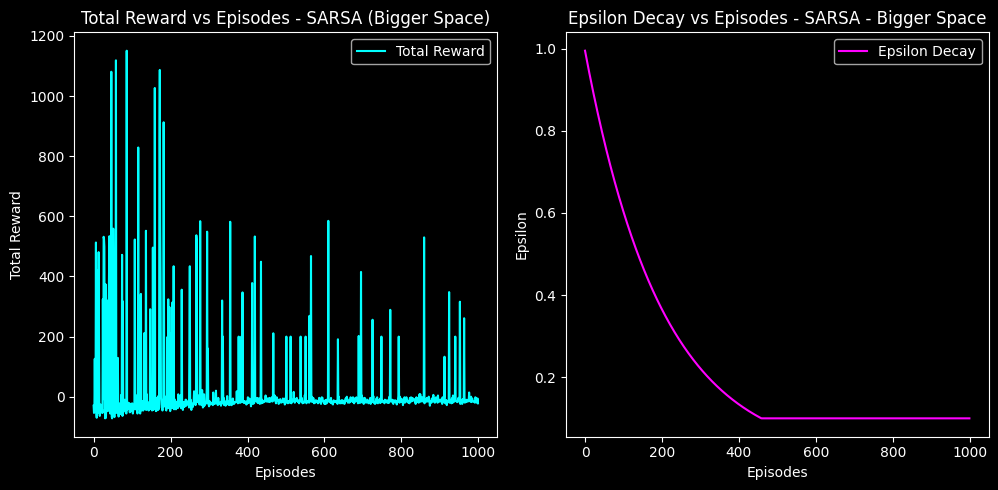

In [12]:
# EVALUATION METRICS
average_reward_sarsa_bs = np.mean(rewards)
success_rate_sarsa_bs = successes / episodes
success_sarsa_bs = successes

print(f"Average Reward: {average_reward_sarsa_bs}")
print(f"Sucesses: {success_sarsa_bs}")
print(f"Success Rate: {success_rate_sarsa_bs}")
plt.style.use('dark_background')
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(rewards, color='cyan', label='Total Reward')
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.title('Total Reward vs Episodes - SARSA (Bigger Space)')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(epsilon_values, color='magenta', label='Epsilon Decay')
plt.xlabel('Episodes')
plt.ylabel('Epsilon')
plt.title('Epsilon Decay vs Episodes - SARSA - Bigger Space')
plt.legend()


plt.tight_layout()
plt.show()

## POLICY GRADIENT - ALGORITHM

- Smaller Space with 5000 episodes
- Bigger Space with 1000 episodes

### Policy Gradient (Smaller Space - 5*10)

In [13]:
class PolicyGradientAgent:
    def __init__(self, env, learning_rate=0.1, gamma=0.99):
        self.env = env
        self.action_space = env.action_space.n
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.policy = {}

    def get_state_key(self, state):
        return (
            tuple(state['robot_position']),
            tuple(state['item_locations']),
            tuple(sorted(state['inventory_levels'].items())),
            tuple(state['order_queue']),
            float(state['battery_level'][0]),
            state['robot_inventory']
        )

    def choose_action(self, state):
        state_key = self.get_state_key(state)
        if state_key not in self.policy:
            self.policy[state_key] = np.random.rand(self.action_space)

        state_policy = self.policy[state_key]
        action_prob = state_policy / np.sum(state_policy)

        if np.any(action_prob < 0) or not np.isclose(np.sum(action_prob), 1):
            print(f"Invalid action_prob for state {state_key}: {action_prob}")
            action_prob = np.ones_like(action_prob) / len(action_prob)

        action = np.random.choice(self.action_space, p=action_prob)
        return action

    def update_policy(self, state_keys, actions, rewards):
        discounted_rewards = np.zeros_like(rewards, dtype=float)
        cumulative_reward = 0
        for t in reversed(range(len(rewards))):
            cumulative_reward = rewards[t] + self.gamma * cumulative_reward
            discounted_rewards[t] = cumulative_reward

        for state_key, action, reward in zip(state_keys, actions, discounted_rewards):
            if state_key not in self.policy:
                self.policy[state_key] = np.random.rand(self.action_space)

            state_policy = self.policy[state_key]
            action_prob = state_policy / np.sum(state_policy)
            grad = np.zeros_like(state_policy)
            grad[action] = 1.0
            self.policy[state_key] += self.learning_rate * reward * (grad - action_prob)
            self.policy[state_key] = np.maximum(self.policy[state_key], 0)

# Create the environment and agent
env = WarehouseEnv(5, 10)
agent = PolicyGradientAgent(env)

# Training the Policy Gradient agent
episodes = 5000
rewards = []
successes = 0
steps_to_goal = []

start_time = time.time()
last_print_time = start_time
print_interval = 10

for episode in range(episodes):
    state = env.reset()
    total_reward = 0
    steps = 0
    max_steps_per_episode = 100
    episode_successes = 0

    state_keys = []
    actions = []
    rewards_list = []

    while True:
        action = agent.choose_action(state)
        next_state, reward, done, _ = env.step(action)

        state_keys.append(agent.get_state_key(state))
        actions.append(action)
        rewards_list.append(reward)

        state = next_state
        total_reward += reward
        steps += 1

        # Check if an order was fulfilled (item successfully dropped)
        if action == 5 and reward >= 0:  # 5 is the 'drop' action and reward >= 0 indicates success
            episode_successes += 1
            steps_to_goal.append(steps)

        if done or steps >= max_steps_per_episode:
            break

    agent.update_policy(state_keys, actions, rewards_list)
    rewards.append(total_reward)
    successes += episode_successes

    if episode % 100 == 0:
        avg_reward_last_100 = np.mean(rewards[-100:]) if len(rewards) >= 100 else np.mean(rewards)
        print(f"Episode: {episode}/{episodes}, Total Reward: {total_reward}, Average Reward (last 100): {avg_reward_last_100:.2f}")
        print(f"Total Successes: {successes}")
        print("--------------------")

print(f"Training completed. Total successes: {successes}")


Episode: 0/5000, Total Reward: 199.9, Average Reward (last 100): 199.90
Total Successes: 0
--------------------
Episode: 100/5000, Total Reward: 213.00000000000054, Average Reward (last 100): 46.72
Total Successes: 58
--------------------
Episode: 200/5000, Total Reward: -76.0, Average Reward (last 100): 22.28
Total Successes: 94
--------------------
Episode: 300/5000, Total Reward: 59.00000000000021, Average Reward (last 100): 28.25
Total Successes: 139
--------------------
Episode: 400/5000, Total Reward: 83.00000000000017, Average Reward (last 100): 61.38
Total Successes: 197
--------------------
Episode: 500/5000, Total Reward: 78.00000000000026, Average Reward (last 100): 49.00
Total Successes: 250
--------------------
Episode: 600/5000, Total Reward: -20.000000000000036, Average Reward (last 100): 44.04
Total Successes: 298
--------------------
Episode: 700/5000, Total Reward: 239.00000000000009, Average Reward (last 100): 41.50
Total Successes: 346
--------------------
Episode: 

Average Reward: 46.97716000000005
Sucesses: 0.5248
Success Rate: 2624


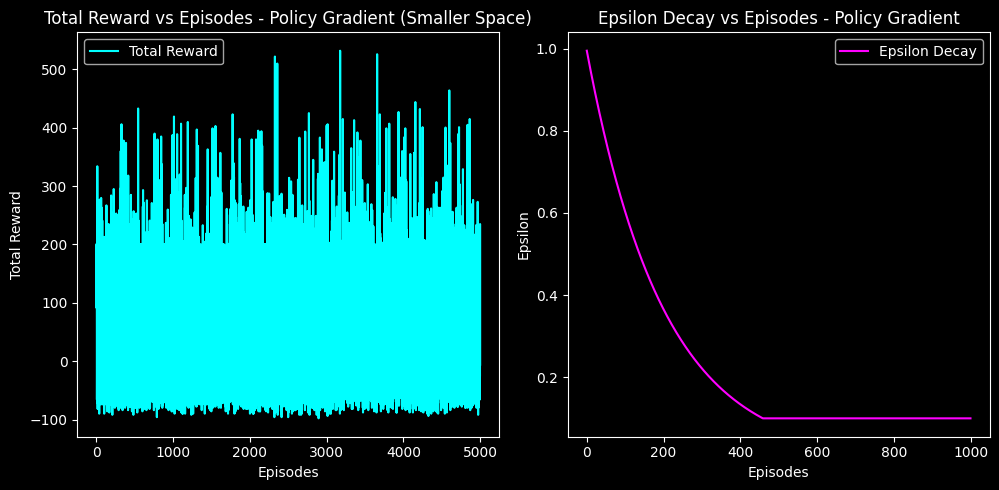

In [14]:
# EVALUATION METRICS
average_reward_pg_ss = np.mean(rewards)
success_rate_pg_ss = successes / episodes
success_pg_ss = successes

print(f"Average Reward: {average_reward_pg_ss}")
print(f"Sucesses: {success_rate_pg_ss}")
print(f"Success Rate: {success_pg_ss}")
plt.style.use('dark_background')
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(rewards, color='cyan', label='Total Reward')
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.title('Total Reward vs Episodes - Policy Gradient (Smaller Space)')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(epsilon_values, color='magenta', label='Epsilon Decay')
plt.xlabel('Episodes')
plt.ylabel('Epsilon')
plt.title('Epsilon Decay vs Episodes - Policy Gradient')
plt.legend()

plt.tight_layout()
plt.show()

### Policy Gradient (Bigger Space - 50*10)

In [15]:
class PolicyGradientAgent:
    def __init__(self, env, learning_rate=0.01, gamma=0.99):
        self.env = env
        self.action_space = env.action_space.n
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.policy = {}

    def get_state_key(self, state):
        return (
            tuple(state['robot_position']),
            tuple(state['item_locations']),
            tuple(sorted(state['inventory_levels'].items())),
            tuple(state['order_queue']),
            float(state['battery_level'][0]),
            state['robot_inventory']
        )

    def choose_action(self, state):
        state_key = self.get_state_key(state)
        if state_key not in self.policy:
            self.policy[state_key] = np.random.rand(self.action_space)

        state_policy = self.policy[state_key]
        action_prob = state_policy / np.sum(state_policy)

        if np.any(action_prob < 0) or not np.isclose(np.sum(action_prob), 1):
            print(f"Invalid action_prob for state {state_key}: {action_prob}")
            action_prob = np.ones_like(action_prob) / len(action_prob)

        action = np.random.choice(self.action_space, p=action_prob)
        return action

    def update_policy(self, state_keys, actions, rewards):
        discounted_rewards = np.zeros_like(rewards, dtype=float)
        cumulative_reward = 0
        for t in reversed(range(len(rewards))):
            cumulative_reward = rewards[t] + self.gamma * cumulative_reward
            discounted_rewards[t] = cumulative_reward

        for state_key, action, reward in zip(state_keys, actions, discounted_rewards):
            if state_key not in self.policy:
                self.policy[state_key] = np.random.rand(self.action_space)

            state_policy = self.policy[state_key]
            action_prob = state_policy / np.sum(state_policy)
            grad = np.zeros_like(state_policy)
            grad[action] = 1.0
            self.policy[state_key] += self.learning_rate * reward * (grad - action_prob)
            self.policy[state_key] = np.maximum(self.policy[state_key], 0)

# Create the environment and agent
env = WarehouseEnv()
agent = PolicyGradientAgent(env)

# Training the Policy Gradient agent
episodes = 1000
rewards = []
successes = 0
steps_to_goal = []

start_time = time.time()
last_print_time = start_time
print_interval = 10

for episode in range(episodes):
    state = env.reset()
    total_reward = 0
    steps = 0
    max_steps_per_episode = 100
    episode_successes = 0

    state_keys = []
    actions = []
    rewards_list = []

    while True:
        action = agent.choose_action(state)
        next_state, reward, done, _ = env.step(action)

        state_keys.append(agent.get_state_key(state))
        actions.append(action)
        rewards_list.append(reward)

        state = next_state
        total_reward += reward
        steps += 1

        # Check if an order was fulfilled (item successfully dropped)
        if action == 5 and reward >= 0:  # 5 is the 'drop' action and reward >= 0 indicates success
            episode_successes += 1
            steps_to_goal.append(steps)

        if done or steps >= max_steps_per_episode:
            break

    agent.update_policy(state_keys, actions, rewards_list)
    rewards.append(total_reward)
    successes += episode_successes

    if episode % 100 == 0:
        avg_reward_last_100 = np.mean(rewards[-100:]) if len(rewards) >= 100 else np.mean(rewards)
        print(f"Episode: {episode}/{episodes}, Total Reward: {total_reward}, Average Reward (last 100): {avg_reward_last_100:.2f}")
        print(f"Total Successes: {successes}")
        print("--------------------")

print(f"Training completed. Total successes: {successes}")


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Episode: 0/1000, Total Reward: -73.99999999999999, Average Reward (last 100): -74.00
Total Successes: 0
--------------------
Episode: 100/1000, Total Reward: -26.000000000000064, Average Reward (last 100): 184.03
Total Successes: 56
--------------------
Episode: 200/1000, Total Reward: -14.00000000000002, Average Reward (last 100): 149.16
Total Successes: 104
--------------------
Episode: 300/1000, Total Reward: 412.99999999999875, Average Reward (last 100): 236.27
Total Successes: 167
--------------------
Episode: 400/1000, Total Reward: 380.99999999999926, Average Reward (last 100): 189.32
Total Successes: 221
--------------------
Episode: 500/1000, Total Reward: -40.0000000000001, Average Reward (last 100): 106.05
Total Successes: 263
--------------------
Episode: 600/1000, Total Reward: -64.00000000000004, Average Reward (last 100): 155.85
Total Successes: 308
--------------------
Episode: 700/1000, Total Reward: -75.99999999999996, Average Reward (last 100): 225.24
Total Successes

Average Reward: 172.2154999999997
Sucesses: 0.523
Success Rate: 0.523


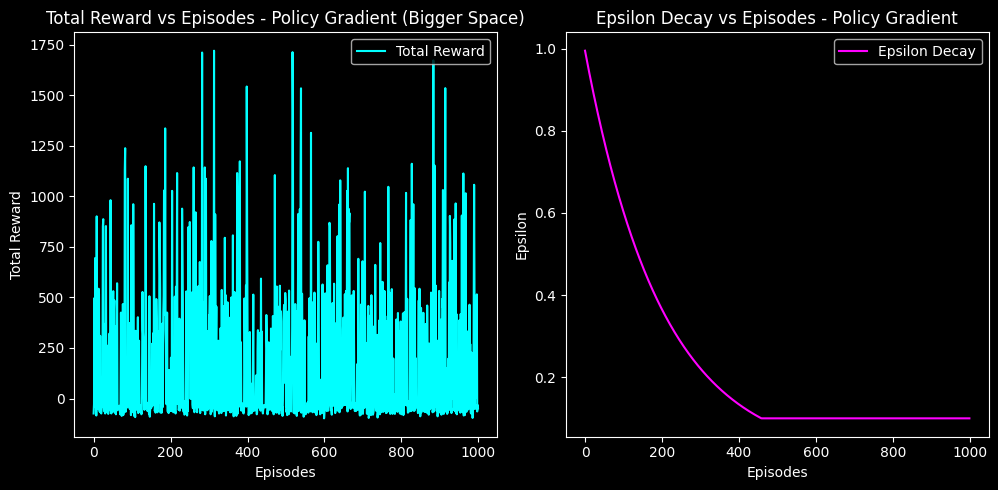

In [16]:
# EVALUATION METRICS
average_reward_pg_bs = np.mean(rewards)
success_rate_pg_bs = successes / episodes
success_pg_bs = successes

print(f"Average Reward: {average_reward_pg_bs}")
print(f"Sucesses: {success_rate_pg_bs}")
print(f"Success Rate: {success_rate_pg_bs}")
plt.style.use('dark_background')
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(rewards, color='cyan', label='Total Reward')
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.title('Total Reward vs Episodes - Policy Gradient (Bigger Space)')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(epsilon_values, color='magenta', label='Epsilon Decay')
plt.xlabel('Episodes')
plt.ylabel('Epsilon')
plt.title('Epsilon Decay vs Episodes - Policy Gradient')
plt.legend()

plt.tight_layout()
plt.show()

## DQN ALGORITHM


- Smaller Space with 1000 episodes
- Bigger Space with 500 episodes

### DQN - (Smaller Space 5*10)

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim

class QNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, action_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class DQNAgent:
    def __init__(self, env, learning_rate=0.001, gamma=0.99, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01, batch_size=64, replay_buffer_size=10000):
        self.env = env
        self.state_dim = self.calculate_state_dim()
        self.action_dim = env.action_space.n
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.batch_size = batch_size
        self.replay_buffer = deque(maxlen=replay_buffer_size)
        self.q_network = QNetwork(self.state_dim, self.action_dim)
        self.target_network = QNetwork(self.state_dim, self.action_dim)
        self.target_network.load_state_dict(self.q_network.state_dict())
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=learning_rate)
        self.loss_fn = nn.MSELoss()

    def calculate_state_dim(self):
        sample_state = self.env.reset()
        return len(self.state_to_vector(sample_state))

    def state_to_vector(self, state):
        robot_position = np.array(state['robot_position'])
        item_locations = np.array(list(state['item_locations'])).flatten()
        inventory_levels = np.array(list(state['inventory_levels'].values()))
        order_queue = np.array(state['order_queue'])
        battery_level = np.array(state['battery_level'])
        robot_inventory = np.array([state['robot_inventory']])

        # Pad or truncate arrays to ensure consistent size
        max_items = self.env.num_items * self.env.num_aisles
        max_orders = self.env.max_orders

        item_locations = np.pad(item_locations, (0, max_items*2 - len(item_locations)), 'constant')
        inventory_levels = np.pad(inventory_levels, (0, self.env.num_items - len(inventory_levels)), 'constant')
        order_queue = np.pad(order_queue, (0, max_orders - len(order_queue)), 'constant', constant_values=-1)

        return np.concatenate([robot_position, item_locations, inventory_levels, order_queue, battery_level, robot_inventory])

    def choose_action(self, state):
        if np.random.rand() <= self.epsilon:
            return self.env.action_space.sample()
        state_vector = self.state_to_vector(state)
        state = torch.FloatTensor(state_vector).unsqueeze(0)
        with torch.no_grad():
            q_values = self.q_network(state)
        return q_values.argmax().item()

    def store_experience(self, state, action, reward, next_state, done):
        state_vector = self.state_to_vector(state)
        next_state_vector = self.state_to_vector(next_state)
        self.replay_buffer.append((state_vector, action, reward, next_state_vector, done))

    def update_q_network(self):
        if len(self.replay_buffer) < self.batch_size:
            return

        batch = random.sample(self.replay_buffer, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        states = torch.FloatTensor(np.array(states))
        actions = torch.LongTensor(actions)
        rewards = torch.FloatTensor(rewards)
        next_states = torch.FloatTensor(np.array(next_states))
        dones = torch.FloatTensor(dones)

        q_values = self.q_network(states).gather(1, actions.unsqueeze(1)).squeeze(1)
        with torch.no_grad():
            next_q_values = self.target_network(next_states).max(1)[0]
            target_q_values = rewards + (1 - dones) * self.gamma * next_q_values

        loss = self.loss_fn(q_values, target_q_values)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def update_target_network(self):
        self.target_network.load_state_dict(self.q_network.state_dict())

    def decay_epsilon(self):
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

# Create the environment and agent
env = WarehouseEnv(5, 10)
agent = DQNAgent(env)

# Training the DQN agent
episodes = 1000
rewards = []
successes = 0
steps_to_goal = []

start_time = time.time()
last_print_time = start_time
print_interval = 10

for episode in range(episodes):
    state = env.reset()
    total_reward = 0
    steps = 0
    max_steps_per_episode = 100
    episode_successes = 0

    while True:
        action = agent.choose_action(state)
        next_state, reward, done, _ = env.step(action)
        agent.store_experience(state, action, reward, next_state, done)
        agent.update_q_network()
        state = next_state
        total_reward += reward
        steps += 1

        # Check if an order was fulfilled (item successfully dropped)
        if action == 5 and reward >= 100:  # 5 is the 'drop' action and reward >= 100 indicates success
            episode_successes += 1
            steps_to_goal.append(steps)

        if done or steps >= max_steps_per_episode:
            break

    if episode % 10 == 0:
        agent.update_target_network()

    agent.decay_epsilon()
    rewards.append(total_reward)
    successes += episode_successes

    if episode % 100 == 0:
        avg_reward_last_100 = np.mean(rewards[-100:]) if len(rewards) >= 100 else np.mean(rewards)
        print(f"Episode: {episode}/{episodes}, Total Reward: {total_reward}, Average Reward (last 100): {avg_reward_last_100:.2f}")
        print(f"Total Successes: {successes}")
        print(f"Epsilon: {agent.epsilon:.4f}")
        print("--------------------")

print(f"Training completed. Total successes: {successes}")


Episode: 0/1000, Total Reward: 553.9999999999989, Average Reward (last 100): 554.00
Total Successes: 4
Epsilon: 0.9950
--------------------
Episode: 100/1000, Total Reward: -66.00000000000011, Average Reward (last 100): 36.38
Total Successes: 55
Epsilon: 0.6027
--------------------
Episode: 200/1000, Total Reward: -147.99999999999977, Average Reward (last 100): 5.35
Total Successes: 94
Epsilon: 0.3651
--------------------
Episode: 300/1000, Total Reward: -105.99999999999984, Average Reward (last 100): -17.55
Total Successes: 127
Epsilon: 0.2212
--------------------
Episode: 400/1000, Total Reward: -91.99999999999976, Average Reward (last 100): -25.20
Total Successes: 150
Epsilon: 0.1340
--------------------
Episode: 500/1000, Total Reward: -75.99999999999999, Average Reward (last 100): -52.29
Total Successes: 167
Epsilon: 0.0812
--------------------
Episode: 600/1000, Total Reward: -107.9999999999997, Average Reward (last 100): -44.52
Total Successes: 172
Epsilon: 0.0492
--------------

Average Reward: -26.714899999999904
Sucesses: 206
Success Rate: 0.206


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


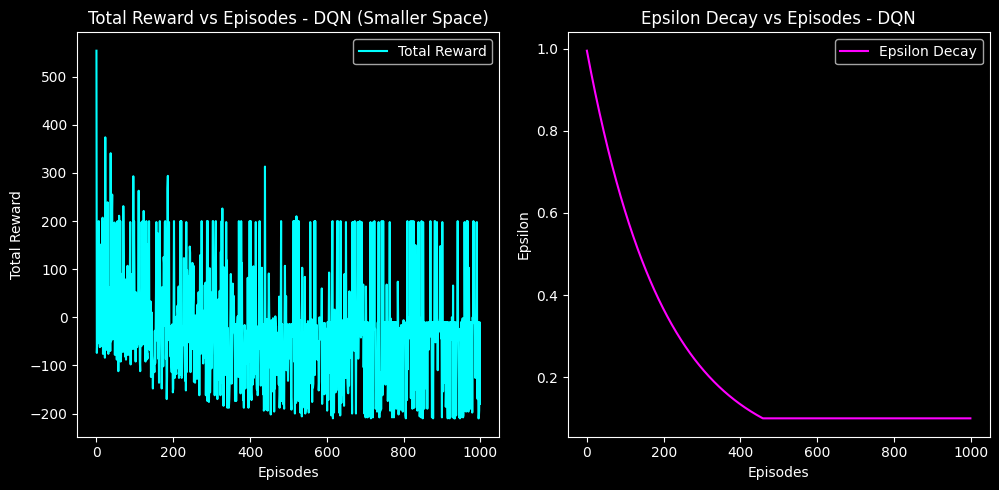

In [18]:
# EVALUATION METRICS
average_reward_dqn = np.mean(rewards)
success_rate_dqn = successes / episodes
success_dqn = successes

print(f"Average Reward: {average_reward_dqn}")
print(f"Sucesses: {success_dqn}")
print(f"Success Rate: {success_rate_dqn}")
plt.style.use('dark_background')
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(rewards, color='cyan', label='Total Reward')
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.title('Total Reward vs Episodes - DQN (Smaller Space)')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(epsilon_values, color='magenta', label='Epsilon Decay')
plt.xlabel('Episodes')
plt.ylabel('Epsilon')
plt.title('Epsilon Decay vs Episodes - DQN')
plt.legend()

plt.tight_layout()
plt.show()

### DQN - (Bigger Space 50*10)

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim

class QNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, action_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class DQNAgent:
    def __init__(self, env, learning_rate=0.001, gamma=0.99, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01, batch_size=64, replay_buffer_size=10000):
        self.env = env
        self.state_dim = self.calculate_state_dim()
        self.action_dim = env.action_space.n
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.batch_size = batch_size
        self.replay_buffer = deque(maxlen=replay_buffer_size)
        self.q_network = QNetwork(self.state_dim, self.action_dim)
        self.target_network = QNetwork(self.state_dim, self.action_dim)
        self.target_network.load_state_dict(self.q_network.state_dict())
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=learning_rate)
        self.loss_fn = nn.MSELoss()

    def calculate_state_dim(self):
        sample_state = self.env.reset()
        return len(self.state_to_vector(sample_state))

    def state_to_vector(self, state):
        robot_position = np.array(state['robot_position'])
        item_locations = np.array(list(state['item_locations'])).flatten()
        inventory_levels = np.array(list(state['inventory_levels'].values()))
        order_queue = np.array(state['order_queue'])
        battery_level = np.array(state['battery_level'])
        robot_inventory = np.array([state['robot_inventory']])

        # Pad or truncate arrays to ensure consistent size
        max_items = self.env.num_items * self.env.num_aisles
        max_orders = self.env.max_orders

        item_locations = np.pad(item_locations, (0, max_items*2 - len(item_locations)), 'constant')
        inventory_levels = np.pad(inventory_levels, (0, self.env.num_items - len(inventory_levels)), 'constant')
        order_queue = np.pad(order_queue, (0, max_orders - len(order_queue)), 'constant', constant_values=-1)

        return np.concatenate([robot_position, item_locations, inventory_levels, order_queue, battery_level, robot_inventory])

    def choose_action(self, state):
        if np.random.rand() <= self.epsilon:
            return self.env.action_space.sample()
        state_vector = self.state_to_vector(state)
        state = torch.FloatTensor(state_vector).unsqueeze(0)
        with torch.no_grad():
            q_values = self.q_network(state)
        return q_values.argmax().item()

    def store_experience(self, state, action, reward, next_state, done):
        state_vector = self.state_to_vector(state)
        next_state_vector = self.state_to_vector(next_state)
        self.replay_buffer.append((state_vector, action, reward, next_state_vector, done))

    def update_q_network(self):
        if len(self.replay_buffer) < self.batch_size:
            return

        batch = random.sample(self.replay_buffer, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        states = torch.FloatTensor(np.array(states))
        actions = torch.LongTensor(actions)
        rewards = torch.FloatTensor(rewards)
        next_states = torch.FloatTensor(np.array(next_states))
        dones = torch.FloatTensor(dones)

        q_values = self.q_network(states).gather(1, actions.unsqueeze(1)).squeeze(1)
        with torch.no_grad():
            next_q_values = self.target_network(next_states).max(1)[0]
            target_q_values = rewards + (1 - dones) * self.gamma * next_q_values

        loss = self.loss_fn(q_values, target_q_values)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def update_target_network(self):
        self.target_network.load_state_dict(self.q_network.state_dict())

    def decay_epsilon(self):
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

# Create the environment and agent
env = WarehouseEnv()
agent = DQNAgent(env)

# Training the DQN agent
episodes = 500
rewards = []
successes = 0
steps_to_goal = []

start_time = time.time()
last_print_time = start_time
print_interval = 10

for episode in range(episodes):
    state = env.reset()
    total_reward = 0
    steps = 0
    max_steps_per_episode = 100
    episode_successes = 0

    while True:
        action = agent.choose_action(state)
        next_state, reward, done, _ = env.step(action)
        agent.store_experience(state, action, reward, next_state, done)
        agent.update_q_network()
        state = next_state
        total_reward += reward
        steps += 1

        # Check if an order was fulfilled (item successfully dropped)
        if action == 5 and reward >= 100:  # 5 is the 'drop' action and reward >= 100 indicates success
            episode_successes += 1
            steps_to_goal.append(steps)

        if done or steps >= max_steps_per_episode:
            break

    if episode % 10 == 0:
        agent.update_target_network()

    agent.decay_epsilon()
    rewards.append(total_reward)
    successes += episode_successes

    if episode % 100 == 0:
        avg_reward_last_100 = np.mean(rewards[-100:]) if len(rewards) >= 100 else np.mean(rewards)
        print(f"Episode: {episode}/{episodes}, Total Reward: {total_reward}, Average Reward (last 100): {avg_reward_last_100:.2f}")
        print(f"Total Successes: {successes}")
        print(f"Epsilon: {agent.epsilon:.4f}")
        print("--------------------")

print(f"Training completed. Total successes: {successes}")


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Episode: 0/500, Total Reward: -32.00000000000003, Average Reward (last 100): -32.00
Total Successes: 0
Epsilon: 0.9950
--------------------
Episode: 100/500, Total Reward: -87.99999999999993, Average Reward (last 100): 142.72
Total Successes: 46
Epsilon: 0.6027
--------------------
Episode: 200/500, Total Reward: 54.000000000000206, Average Reward (last 100): 74.36
Total Successes: 84
Epsilon: 0.3651
--------------------
Episode: 300/500, Total Reward: -121.99999999999987, Average Reward (last 100): 14.07
Total Successes: 108
Epsilon: 0.2212
--------------------
Episode: 400/500, Total Reward: -64.00000000000013, Average Reward (last 100): -11.35
Total Successes: 132
Epsilon: 0.1340
--------------------
Training completed. Total successes: 145


Average Reward: 34.364199999999904
Sucesses: 145
Success Rate: 0.29


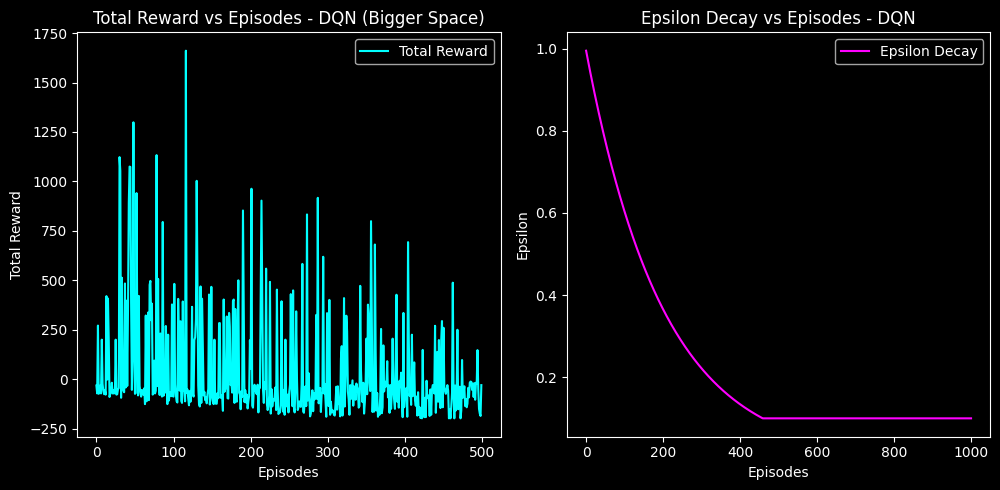

In [20]:
# EVALUATION METRICS
average_reward_dqn_bs = np.mean(rewards)
success_rate_dqn_bs = successes / episodes
success_dqn_bs = successes

print(f"Average Reward: {average_reward_dqn_bs}")
print(f"Sucesses: {success_dqn_bs}")
print(f"Success Rate: {success_rate_dqn_bs}")
plt.style.use('dark_background')
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(rewards, color='cyan', label='Total Reward')
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.title('Total Reward vs Episodes - DQN (Bigger Space)')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(epsilon_values, color='magenta', label='Epsilon Decay')
plt.xlabel('Episodes')
plt.ylabel('Epsilon')
plt.title('Epsilon Decay vs Episodes - DQN')
plt.legend()

plt.tight_layout()
plt.show()

## SUMMARY

In [ ]:
results = {
    "Algorithm": ["Q-Learning (SS)", "SARSA (SS)", "Policy Gradient (SS)", "DQN (SS)", "Q-Learning (BS)", "SARSA (BS)", "Policy Gradient (BS)", "DQN (BS)"],
    "Average Reward": [average_reward_ql_ss, average_reward_sarsa_ss, average_reward_pg_ss, average_reward_dqn, average_reward_ql_bs, average_reward_sarsa_bs, average_reward_pg_bs, average_reward_dqn_bs],
    "Success Rate": [success_rate_ql_ss, success_rate_sarsa_ss, success_rate_pg_ss, success_rate_dqn, success_rate_ql_bs, success_rate_sarsa_bs, success_rate_pg_bs, success_rate_dqn_bs],
}

df = pd.DataFrame(results)

print(tabulate(df, headers='keys', tablefmt='pretty'))

In [ ]:
plt.style.use('dark_background')

# Data
algorithms = df['Algorithm']
average_rewards = df['Average Reward']
success_rates = df['Success Rate']


x = np.arange(len(algorithms))

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(18, 5))

# Plot Average Reward
axs[0].bar(x, average_rewards, color='skyblue')
axs[0].set_xticks(x)
axs[0].set_xticklabels(algorithms, rotation=45)
axs[0].set_ylabel('Average Reward')
axs[0].set_title('Average Reward by Algorithm')

# Plot Success Rate
axs[1].bar(x, success_rates, color='lightgreen')
axs[1].set_xticks(x)
axs[1].set_xticklabels(algorithms, rotation=45)
axs[1].set_ylabel('Success Rate')
axs[1].set_title('Success Rate by Algorithm')


plt.tight_layout()
plt.show()